ANALISIS ATRIBUTOS CALCULADOS vs REALES

In [22]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import StandardScaler

In [23]:
# Cargar los datasets reales y calculados para cada técnica
real_data = pd.read_csv("final_static_data.csv")
tvae_data = pd.read_csv("atributos_calculados_TVAE.csv")
gaussian_data = pd.read_csv("atributos_calculados_GaussianCopula.csv")
ctgan_data = pd.read_csv("atributos_calculados_CTGAN.csv")


In [30]:
import pandas as pd
import numpy as np

# Cargar los archivos CSV
tvae_data = pd.read_csv("atributos_calculados_TVAE.csv")
gaussian_data = pd.read_csv("atributos_calculados_GaussianCopula.csv")
ctgan_data = pd.read_csv("atributos_calculados_CTGAN.csv")

# Función para analizar valores NaN e Infinitos
def analizar_valores_problema(df, nombre):
    # Seleccionar solo columnas numéricas
    df_numeric = df.select_dtypes(include=[np.number])
    
    # Contar valores NaN e Infinitos
    nan_counts = df_numeric.isna().sum()
    inf_counts = np.isinf(df_numeric).sum()
    
    # Crear DataFrame con los resultados
    df_issues = pd.DataFrame({
        "Columnas": df_numeric.columns,
        "Valores NaN": nan_counts.values,
        "Valores Infinitos": inf_counts.values
    })

    # Mostrar solo columnas con problemas
    print(f"\nResumen de valores NaN e Infinitos en {nombre}:")
    
    nan_problems = df_issues[df_issues["Valores NaN"] > 0]
    inf_problems = df_issues[df_issues["Valores Infinitos"] > 0]
    
    if not nan_problems.empty:
        print("\nColumnas con NaN:")
        print(nan_problems)
    
    if not inf_problems.empty:
        print("\nColumnas con valores Infinitos:")
        print(inf_problems)
    
    if nan_problems.empty and inf_problems.empty:
        print("No se encontraron valores NaN ni Infinitos.")

# Ejecutar la función en los tres archivos
analizar_valores_problema(tvae_data, "TVAE")
analizar_valores_problema(gaussian_data, "Gaussian Copula")
analizar_valores_problema(ctgan_data, "CTGAN")



Resumen de valores NaN e Infinitos en TVAE:
No se encontraron valores NaN ni Infinitos.

Resumen de valores NaN e Infinitos en Gaussian Copula:
No se encontraron valores NaN ni Infinitos.

Resumen de valores NaN e Infinitos en CTGAN:

Columnas con NaN:
   Columnas  Valores NaN  Valores Infinitos
16      aol           15                  0

Columnas con valores Infinitos:
  Columnas  Valores NaN  Valores Infinitos
8    ldivw            0                  2


In [34]:
# Función para comparar cada conjunto sintético con los datos reales
def comparar_con_reales(real_data, synthetic_data, nombre):
    print(f"\nComparación de {nombre} con datos reales:\n")

    # Selección de atributos
    atributos = ["len", "wid", "ldivw", "ldivd", "wdivd", "area", "grith", "aml", "amt", "vs", "aol"]

    # Limpieza de datos sintéticos: Eliminar NaN en 'aol' y Infinitos en 'ldivw'
    antes = synthetic_data.shape[0]
    synthetic_data = synthetic_data.dropna(subset=["aol"])  # Elimina NaN en 'aol'
    synthetic_data = synthetic_data[~np.isinf(synthetic_data["ldivw"])]  # Elimina Infinitos en 'ldivw'
    despues = synthetic_data.shape[0]
    
    print(f" Eliminadas {antes - despues} filas con NaN o Infinitos en {nombre}.")

    # Limpieza de datos reales: Eliminar cualquier NaN si los hay
    real_data = real_data.dropna(subset=atributos)

    # Comparación de estadísticas descriptivas
    stats_df = []
    for attr in atributos:
        for dataset, dataset_name in zip([real_data, synthetic_data], ["Real", nombre]):
            stats_df.append({
                'Atributo': attr,
                'Dataset': dataset_name,
                'Media': dataset[attr].mean(),
                'Mediana': dataset[attr].median(),
                'Desviación Estándar': dataset[attr].std(),
                'Asimetría': stats.skew(dataset[attr]),
                'Min': dataset[attr].min(),  
                'Max': dataset[attr].max()   
            })
    stats_df = pd.DataFrame(stats_df)
    print(stats_df)

    # Comparación de distribuciones con KS-Test
    ks_results = []
    for attr in atributos:
        ks_stat, p_value = ks_2samp(real_data[attr], synthetic_data[attr])
        ks_results.append({'Atributo': attr, 'KS-Statistic': ks_stat, 'P-Value': p_value})
    ks_results = pd.DataFrame(ks_results)
    print("\nResultados KS-Test:")
    print(ks_results)

    # Visualización: Histogramas KDE con medias y medianas
    for attr in atributos:
        plt.figure(figsize=(10, 5))
        sns.kdeplot(real_data[attr], label='Real', fill=True, alpha=0.5, color="blue")
        sns.kdeplot(synthetic_data[attr], label=nombre, fill=True, alpha=0.5, color="orange")

        # Calcular medias y medianas
        mean_real, median_real = real_data[attr].mean(), real_data[attr].median()
        mean_synth, median_synth = synthetic_data[attr].mean(), synthetic_data[attr].median()

        # Añadir líneas verticales de media y mediana
        plt.axvline(mean_real, color="green", linestyle="dashed", label=f"Media Real: {mean_real:.2f}")
        plt.axvline(median_real, color="red", linestyle="solid", label=f"Mediana Real: {median_real:.2f}")
        plt.axvline(mean_synth, color="orange", linestyle="dashed", label=f"Media Sintética: {mean_synth:.2f}")
        plt.axvline(median_synth, color="purple", linestyle="solid", label=f"Mediana Sintética: {median_synth:.2f}")

        plt.title(f'Distribución de {attr}')
        plt.legend()
        plt.show()

    # Comparación de correlaciones
    correlation_matrices = {
        "Real": real_data[atributos].corr(),
        nombre: synthetic_data[atributos].corr()
    }

    # Visualización de matrices de correlación
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    for ax, (dataset_name, matrix) in zip(axes.flatten(), correlation_matrices.items()):
        sns.heatmap(matrix, ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
        ax.set_title(f'Matriz de correlación - {dataset_name}')
    plt.tight_layout()
    plt.show()

    # Gestión de valores NaN antes de PCA y t-SNE
    real_data_clean = real_data[atributos].dropna()
    synthetic_data_clean = synthetic_data[atributos].dropna()

    # Verificación antes de PCA y t-SNE
    if real_data_clean.empty or synthetic_data_clean.empty:
        print("Error: No hay suficientes datos limpios para PCA/t-SNE. Omitiendo este análisis.")
        return

    # 🔹 Escalar los datos
    scaler = StandardScaler()
    combined_data = pd.concat([real_data_clean, synthetic_data_clean])
    combined_scaled = scaler.fit_transform(combined_data)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(combined_scaled)

    df_pca = pd.DataFrame(X_pca, columns=["PCA 1", "PCA 2"])
    df_pca["Tipo"] = ["Real"] * len(real_data_clean) + [nombre] * len(synthetic_data_clean)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_pca, x="PCA 1", y="PCA 2", hue="Tipo", alpha=0.6)
    plt.title(f"PCA - Comparación de {nombre} vs. Datos Reales")
    plt.legend()
    plt.show()

    #  t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(combined_scaled)

    df_tsne = pd.DataFrame(X_tsne, columns=["t-SNE 1", "t-SNE 2"])
    df_tsne["Tipo"] = ["Real"] * len(real_data_clean) + [nombre] * len(synthetic_data_clean)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_tsne, x="t-SNE 1", y="t-SNE 2", hue="Tipo", alpha=0.6)
    plt.title(f"t-SNE - Comparación de {nombre} vs. Datos Reales")
    plt.legend()
    plt.show()

    print("\nComparación finalizada.\n")



Comparación de TVAE con datos reales:

 Eliminadas 0 filas con NaN o Infinitos en TVAE.
   Atributo Dataset         Media       Mediana  Desviación Estándar  \
0       len    Real    129.530229    116.000000            84.735602   
1       len    TVAE    131.210575    122.730652            83.886630   
2       wid    Real     21.649322     18.000000            12.449835   
3       wid    TVAE     21.649943     19.512226            11.423541   
4     ldivw    Real      5.630652      5.966667             1.659620   
5     ldivw    TVAE      5.676378      5.977679             1.853242   
6     ldivd    Real     20.328037     19.898260            14.811206   
7     ldivd    TVAE     19.428151     20.014841            10.645566   
8     wdivd    Real      3.506503      3.324340             1.743035   
9     wdivd    TVAE      3.391947      3.308933             1.287316   
10     area    Real   3819.197069   2040.000000          4094.834340   
11     area    TVAE   3742.452580   2327.651745

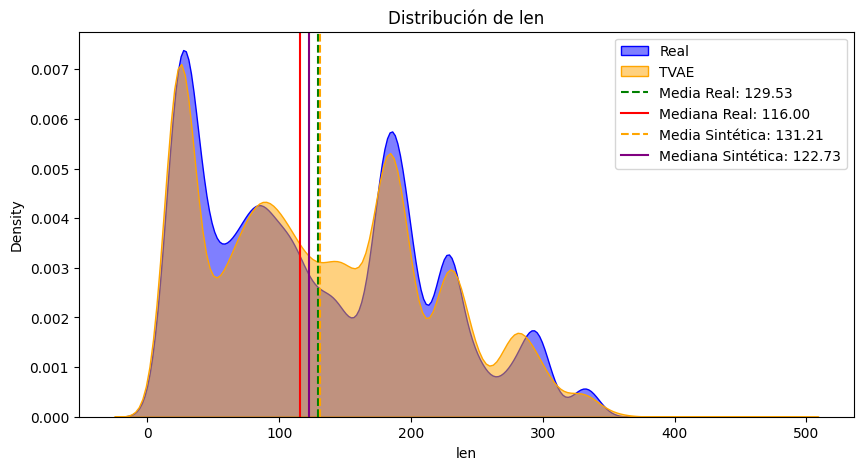

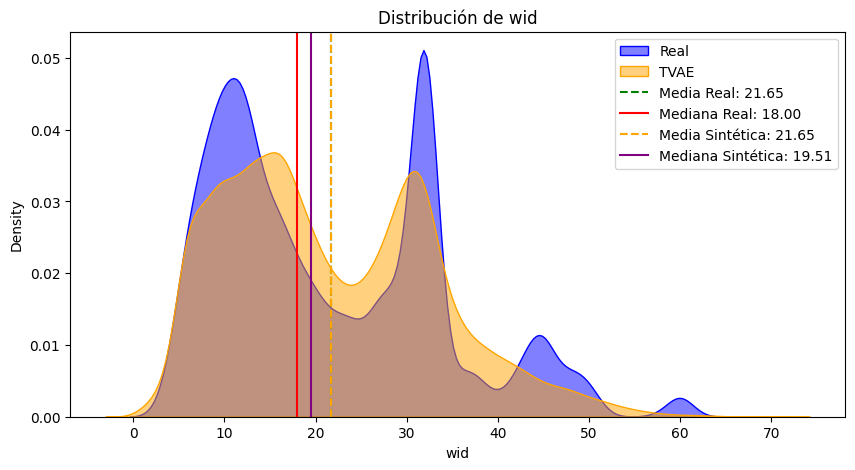

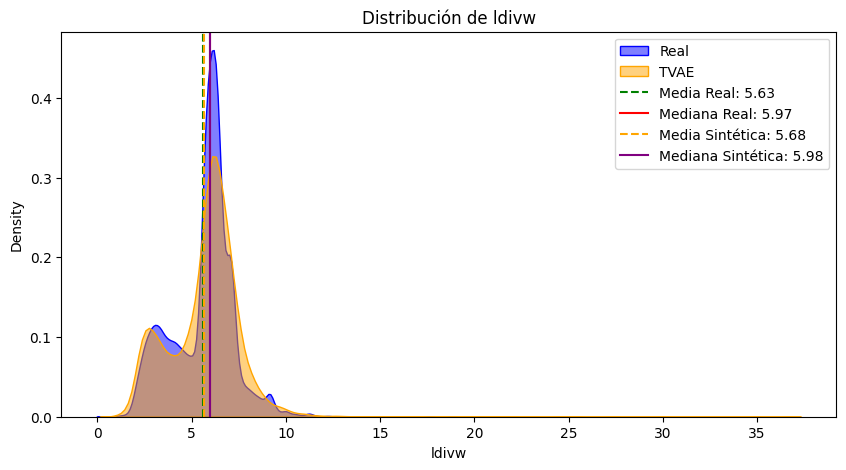

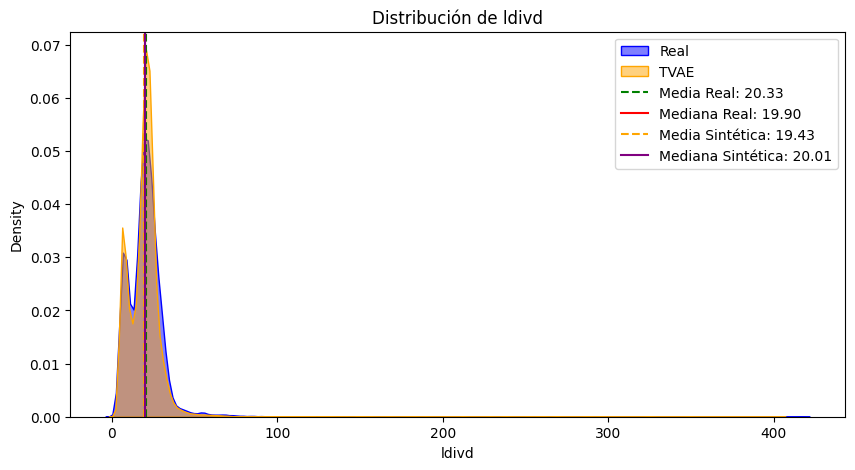

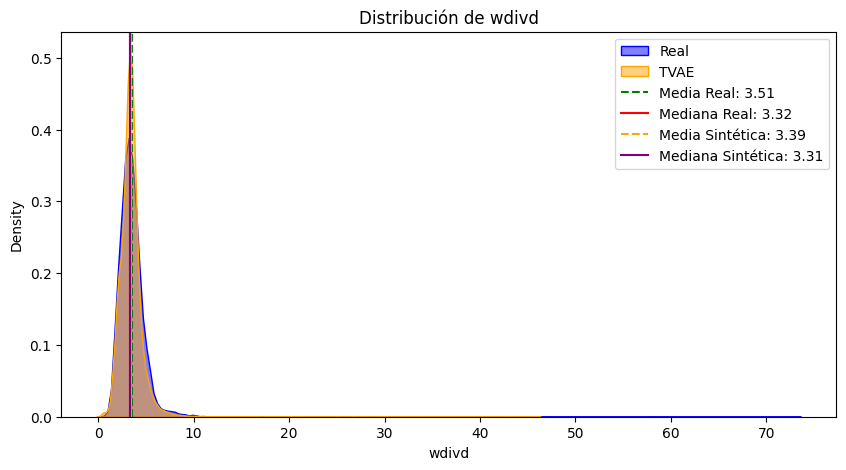

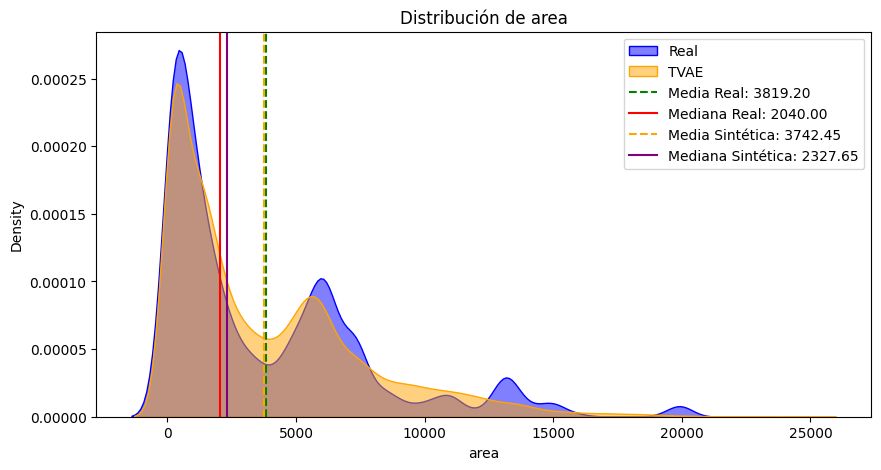

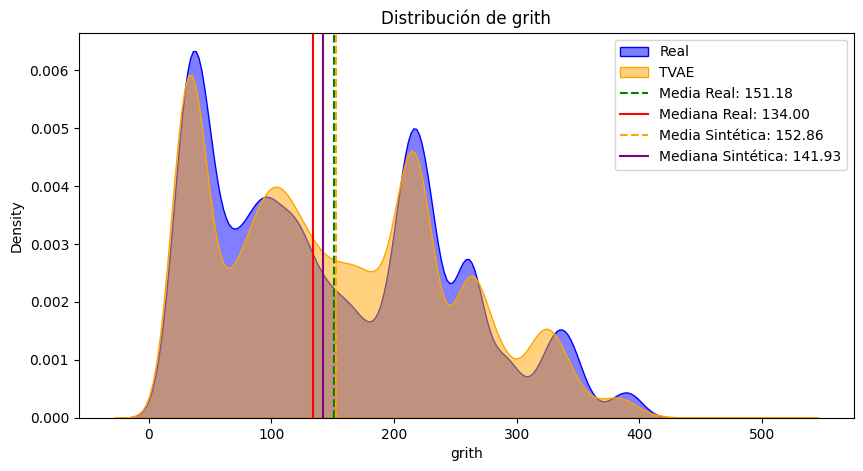

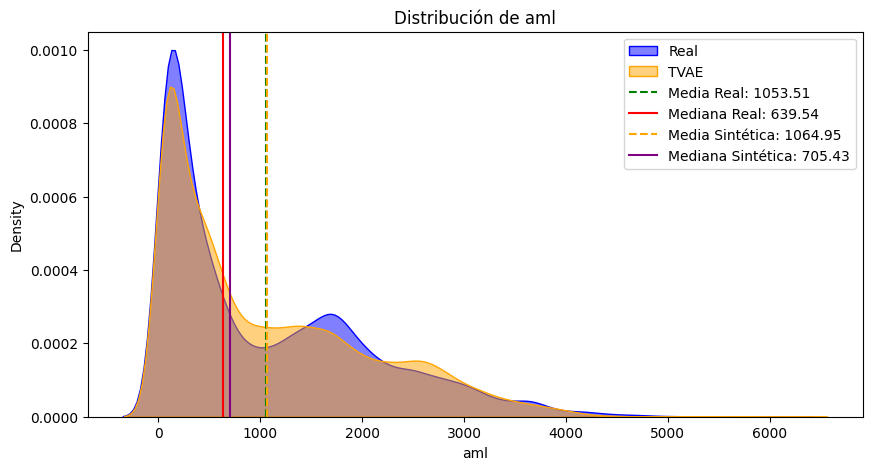

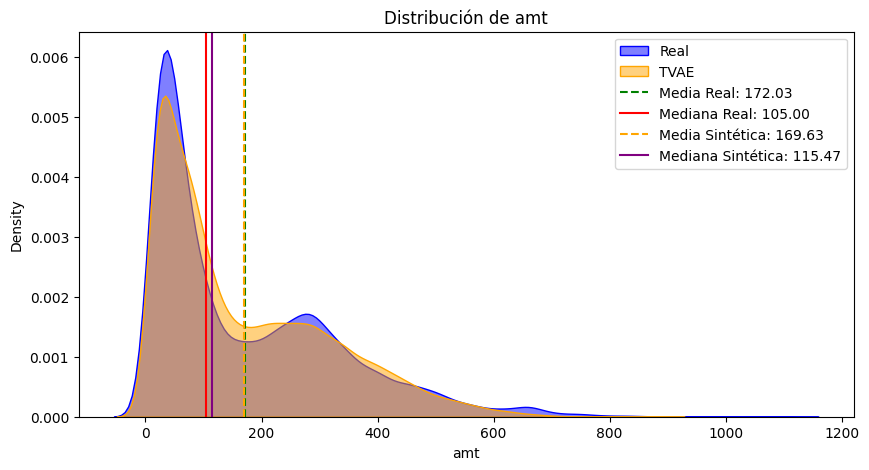

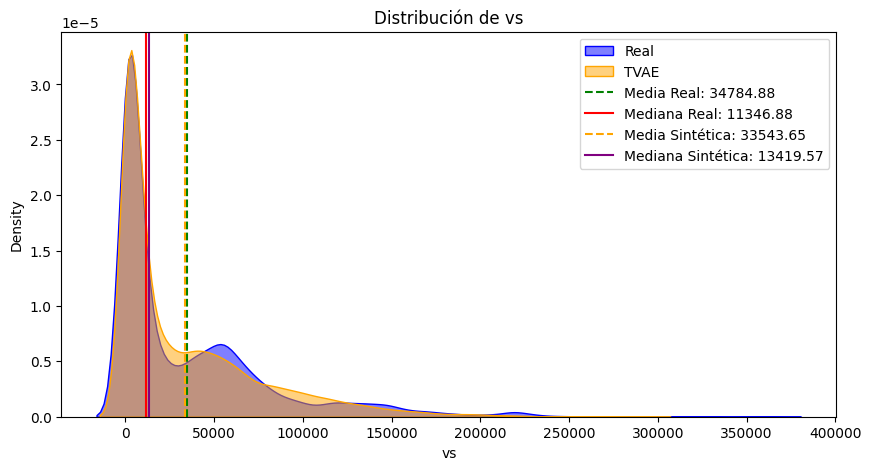

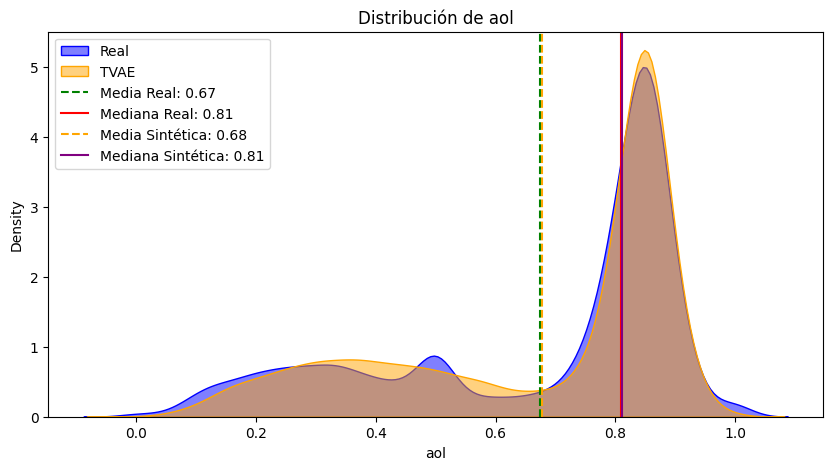

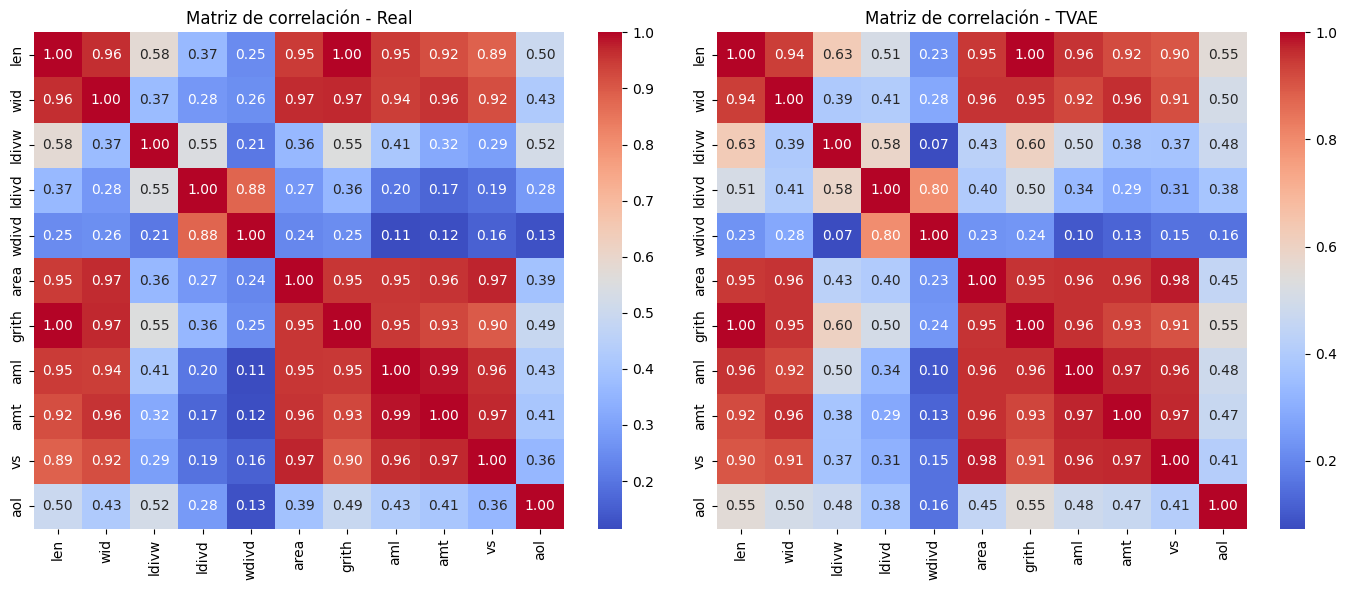

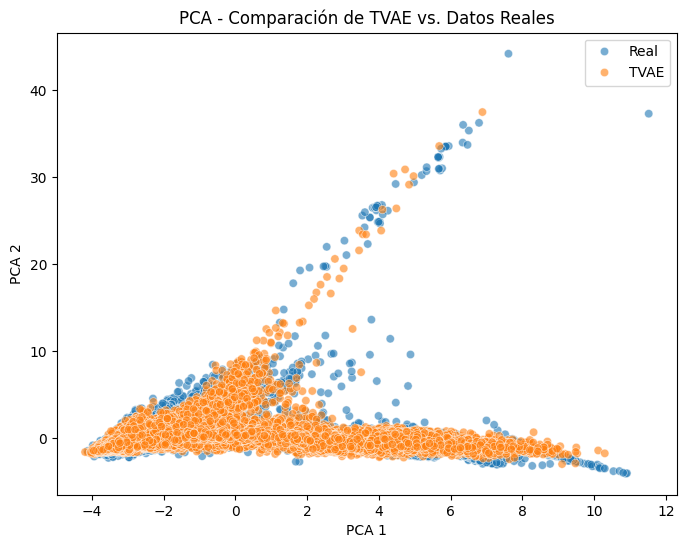

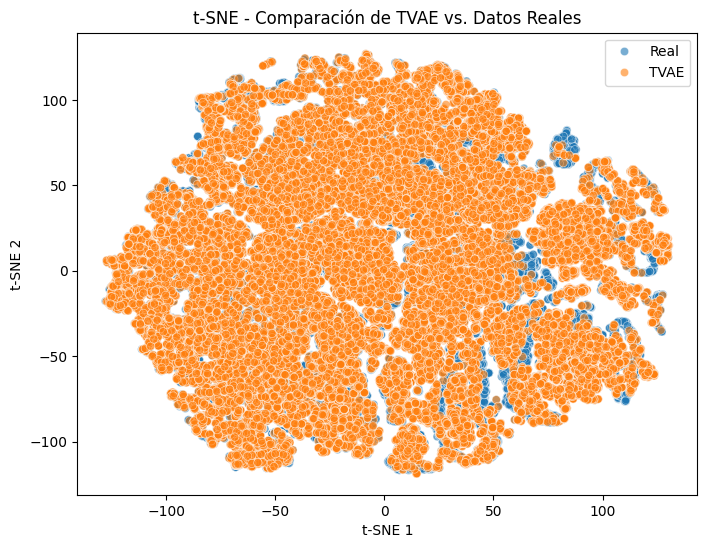


Comparación finalizada.


Comparación de GaussianCopula con datos reales:

 Eliminadas 0 filas con NaN o Infinitos en GaussianCopula.
   Atributo         Dataset         Media       Mediana  Desviación Estándar  \
0       len            Real    129.530229    116.000000            84.735602   
1       len  GaussianCopula    129.088979    122.136503            84.477487   
2       wid            Real     21.649322     18.000000            12.449835   
3       wid  GaussianCopula     21.704370     19.793811            12.386502   
4     ldivw            Real      5.630652      5.966667             1.659620   
5     ldivw  GaussianCopula      5.640698      5.746897             1.897287   
6     ldivd            Real     20.328037     19.898260            14.811206   
7     ldivd  GaussianCopula     19.685134     19.513561            10.490595   
8     wdivd            Real      3.506503      3.324340             1.743035   
9     wdivd  GaussianCopula      3.467792      3.302746          

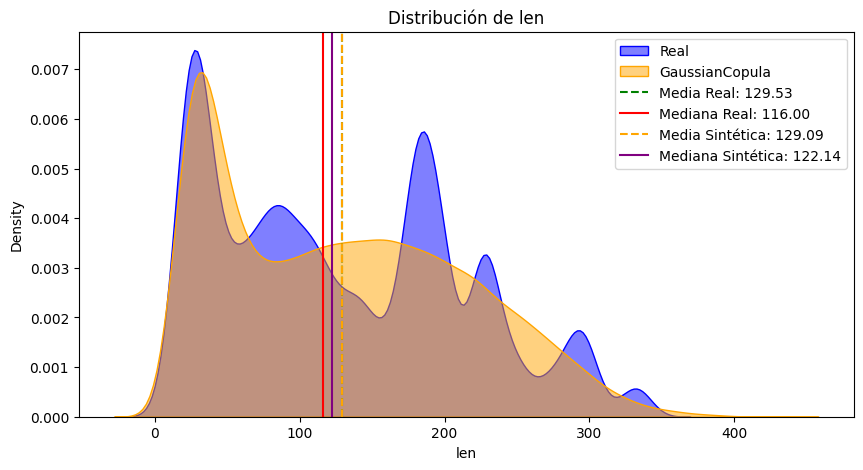

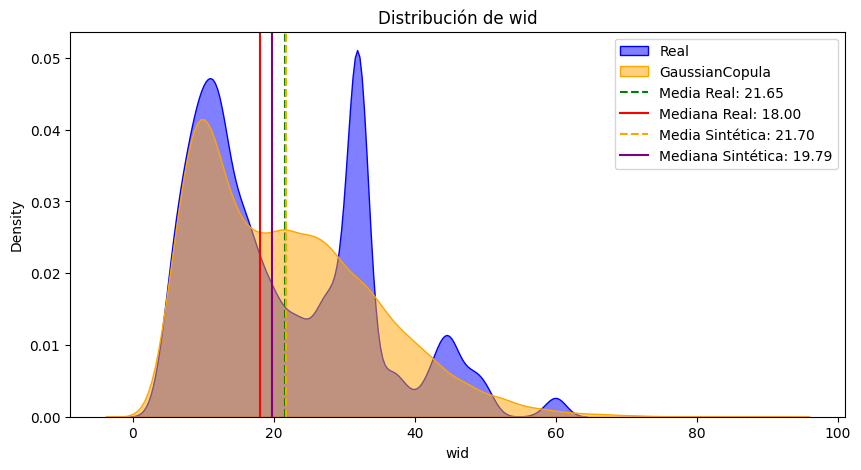

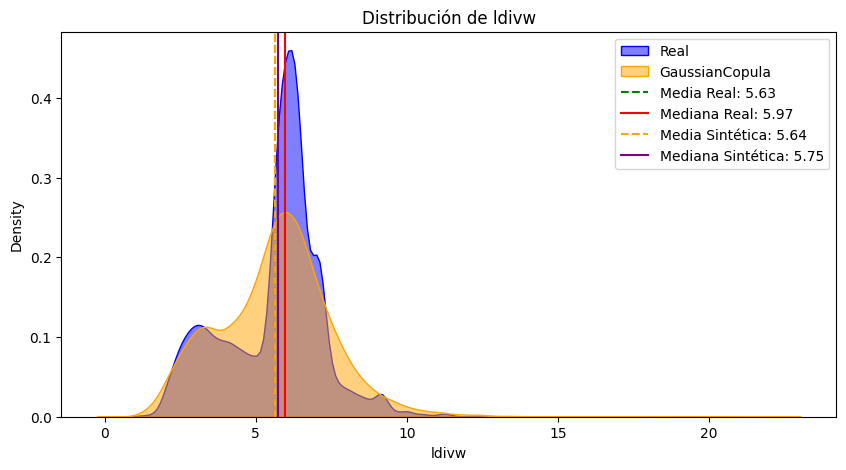

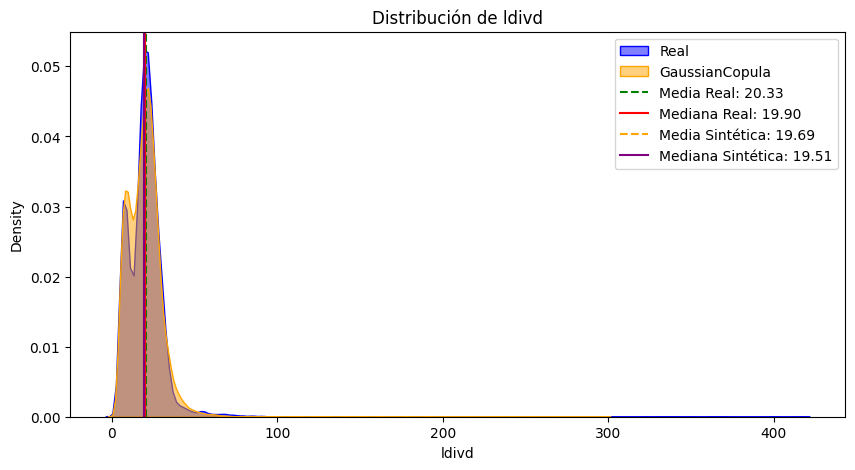

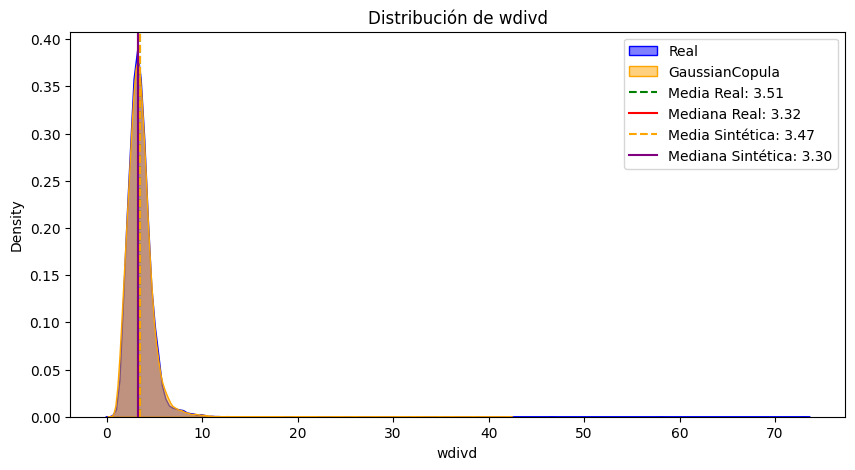

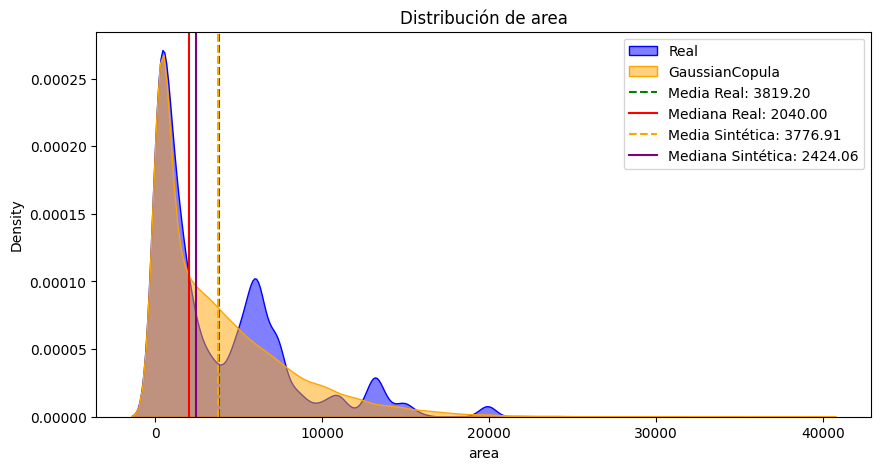

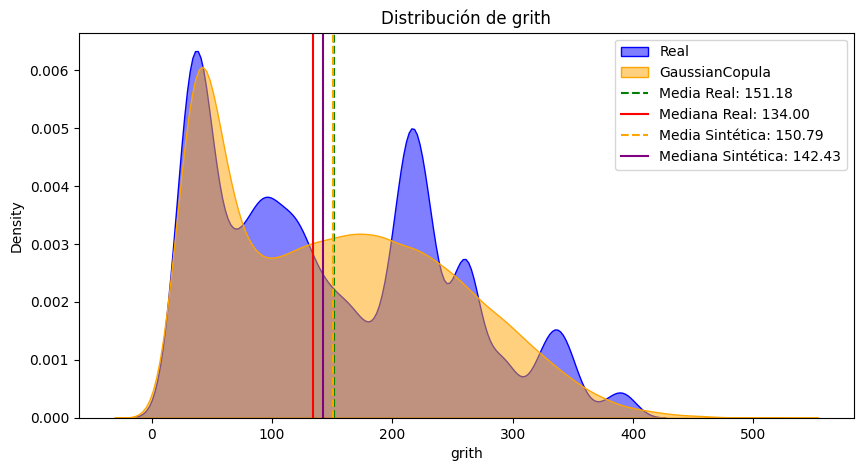

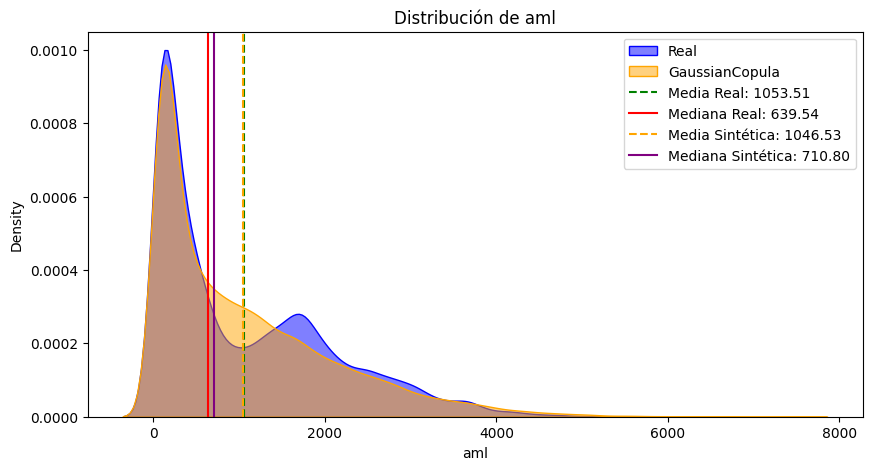

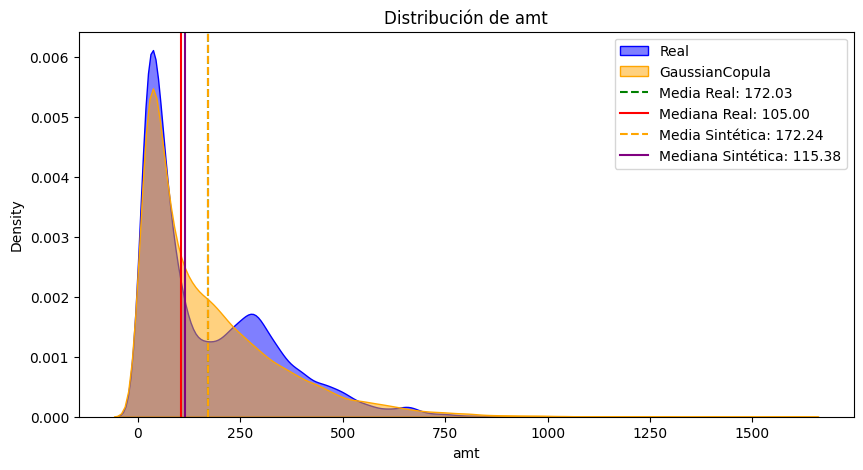

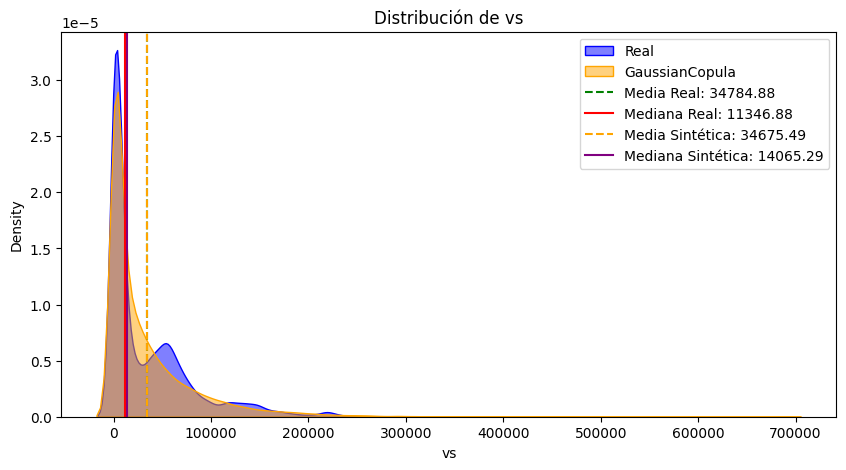

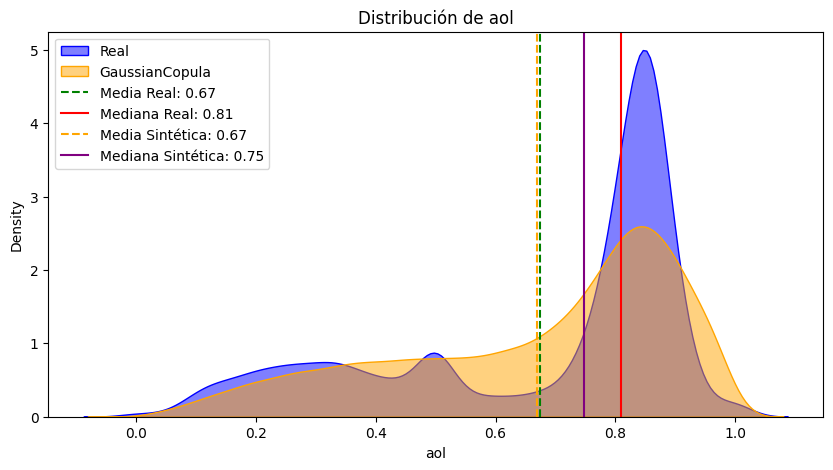

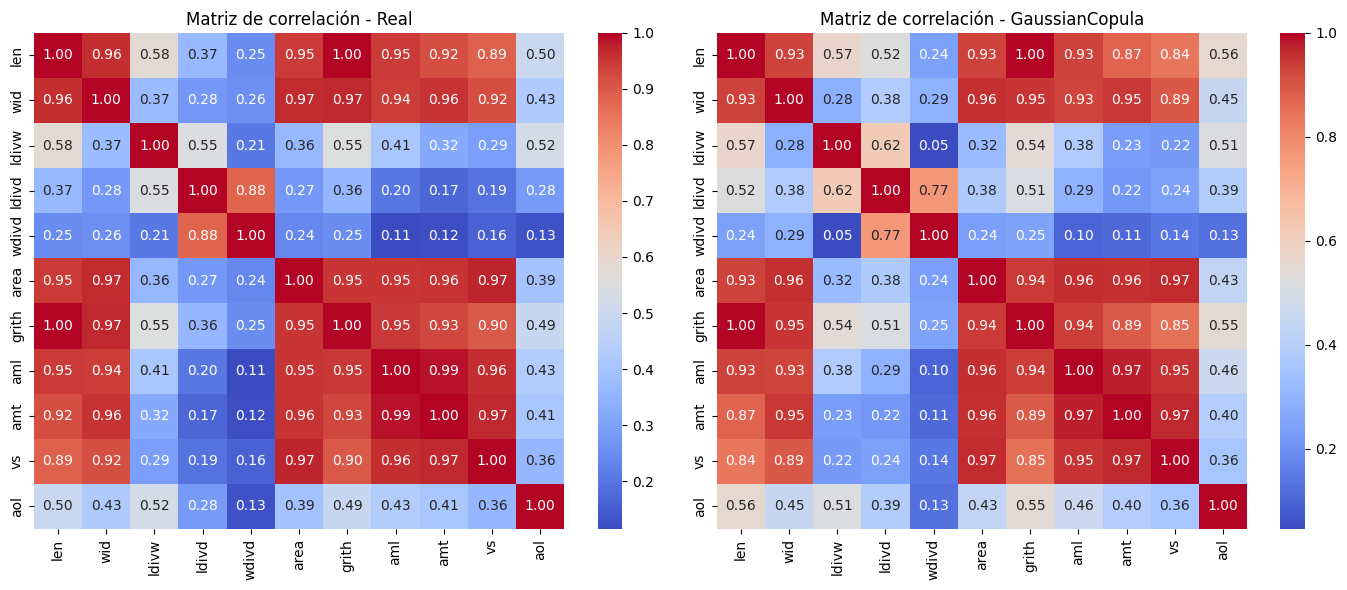

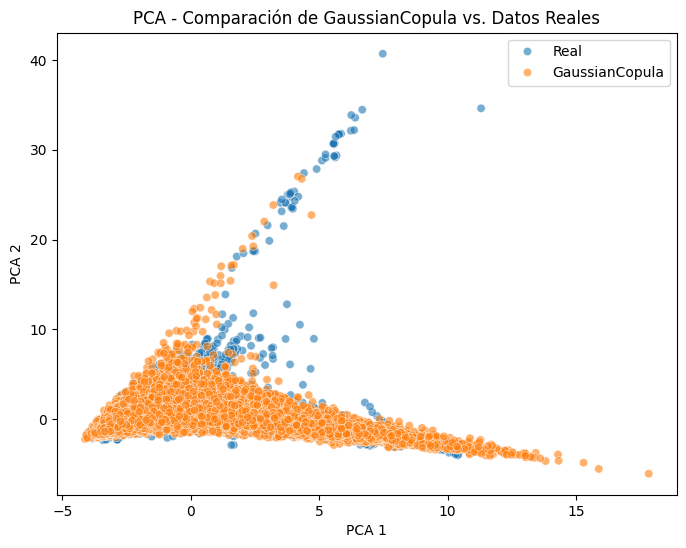

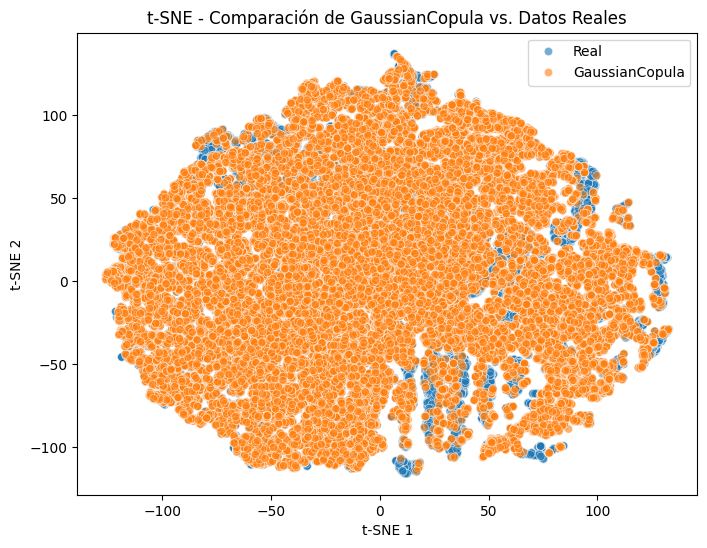


Comparación finalizada.


Comparación de CTGAN con datos reales:

 Eliminadas 17 filas con NaN o Infinitos en CTGAN.
   Atributo Dataset         Media       Mediana  Desviación Estándar  \
0       len    Real    129.530229    116.000000            84.735602   
1       len   CTGAN    126.523475    104.590857            88.346397   
2       wid    Real     21.649322     18.000000            12.449835   
3       wid   CTGAN     21.474860     18.027010            12.979183   
4     ldivw    Real      5.630652      5.966667             1.659620   
5     ldivw   CTGAN      5.882630      5.635578             3.209104   
6     ldivd    Real     20.328037     19.898260            14.811206   
7     ldivd   CTGAN     20.139121     18.897892            16.059600   
8     wdivd    Real      3.506503      3.324340             1.743035   
9     wdivd   CTGAN      3.626345      3.278974             2.601635   
10     area    Real   3819.197069   2040.000000          4094.834340   
11     area   CTGA

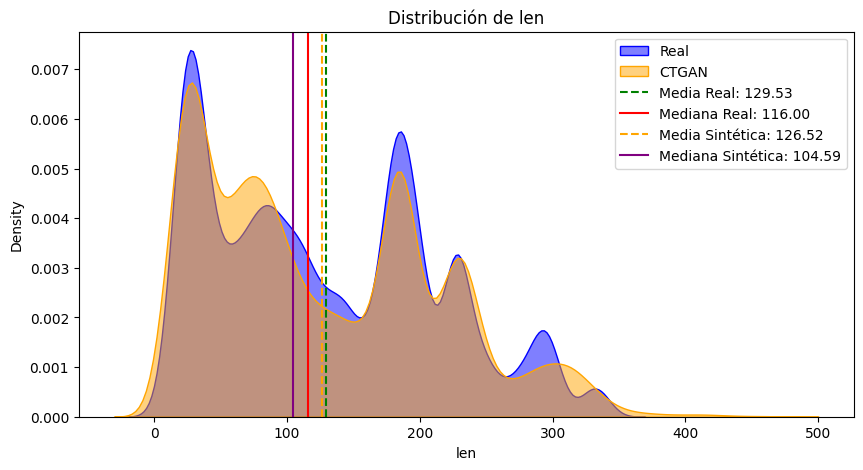

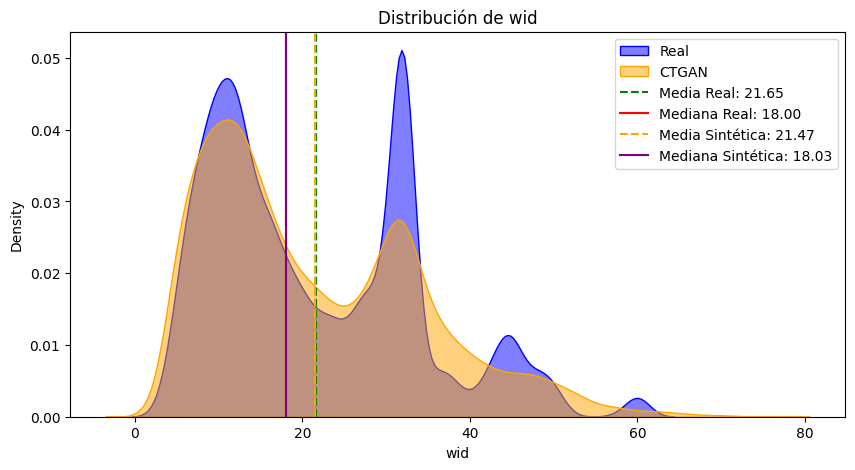

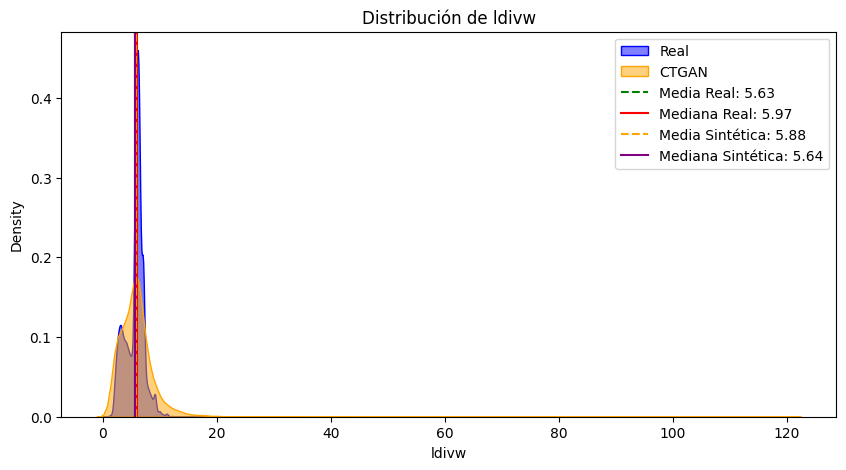

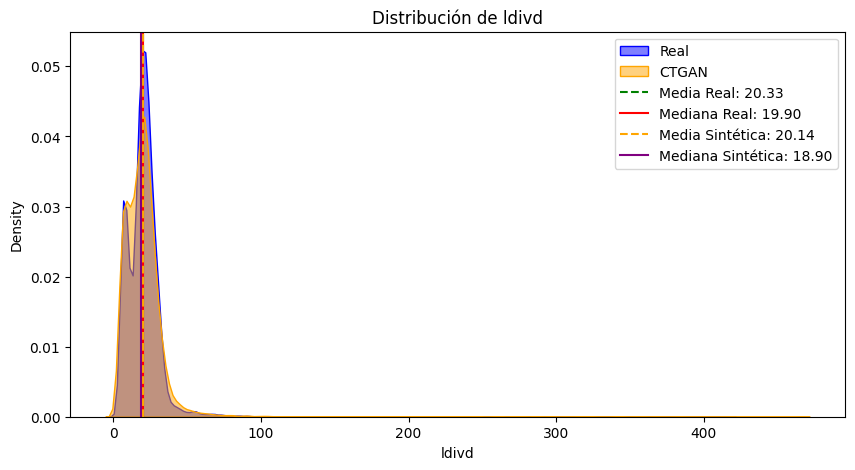

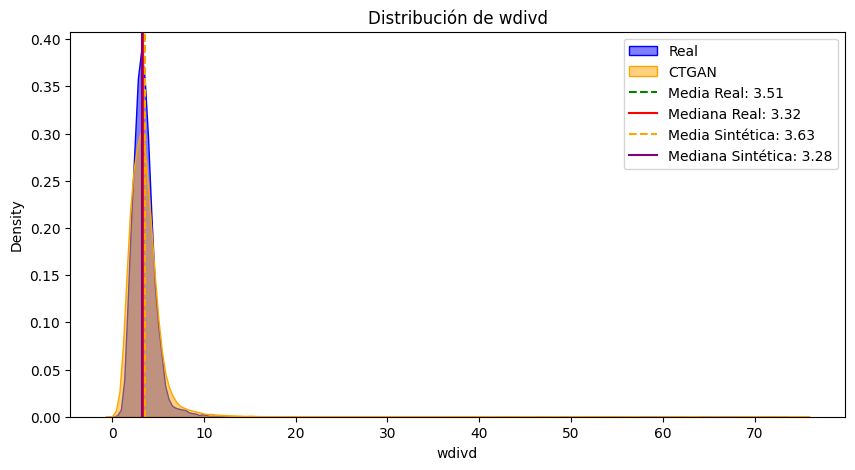

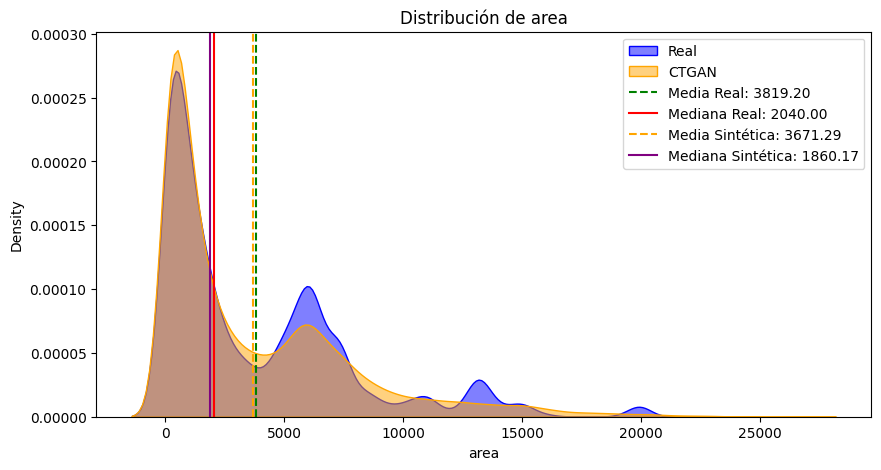

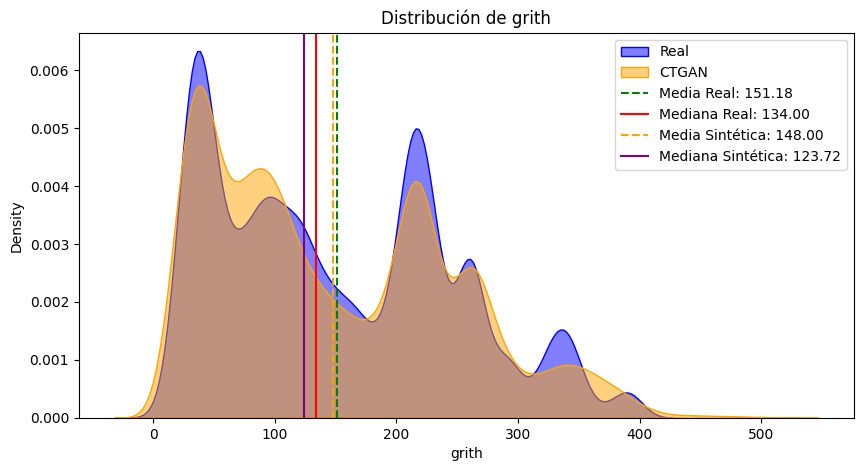

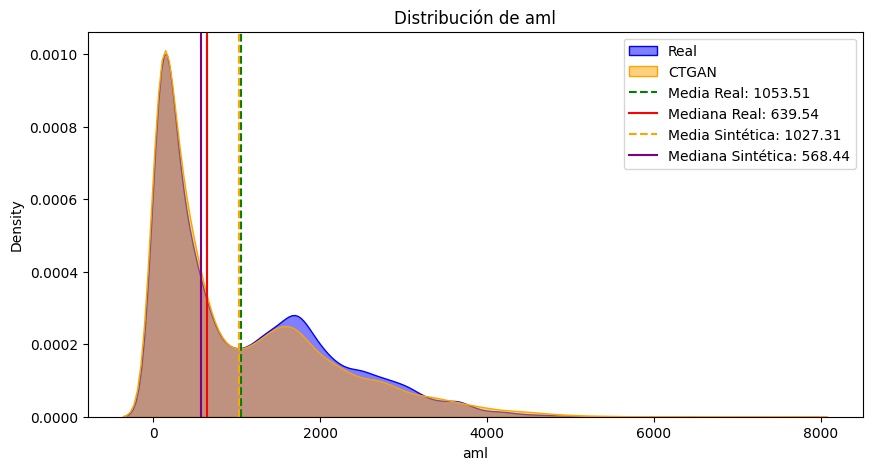

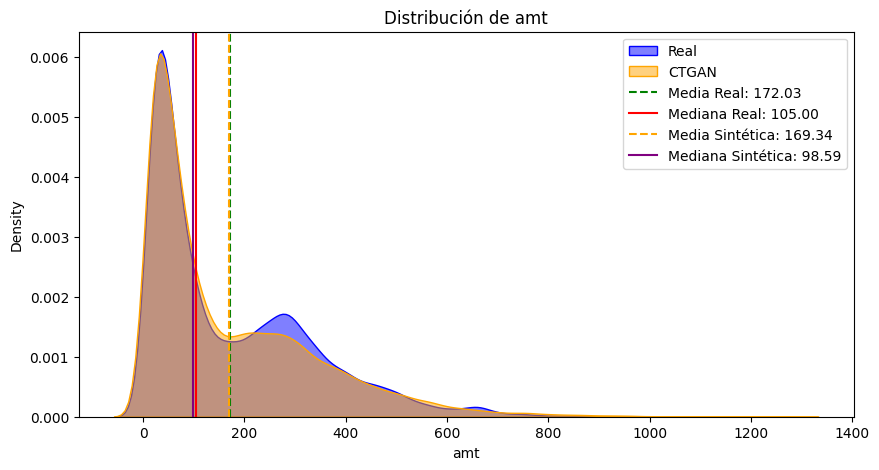

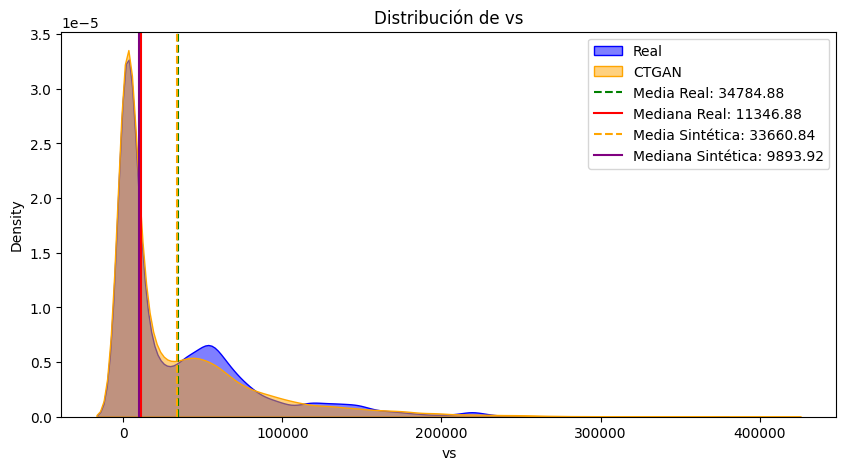

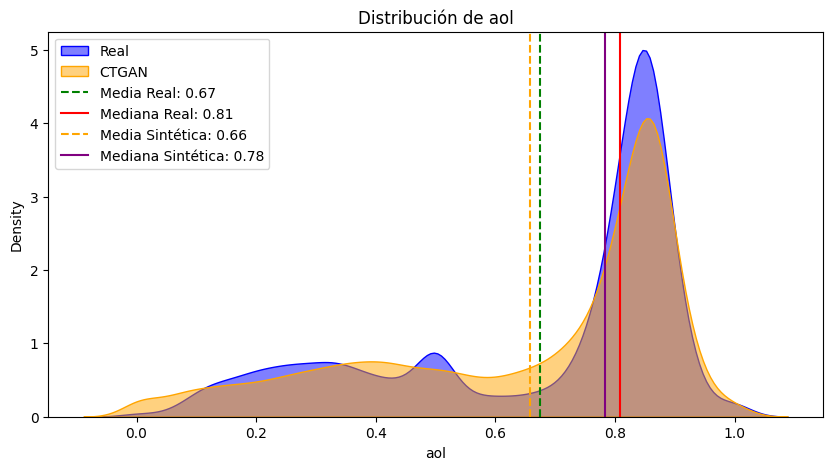

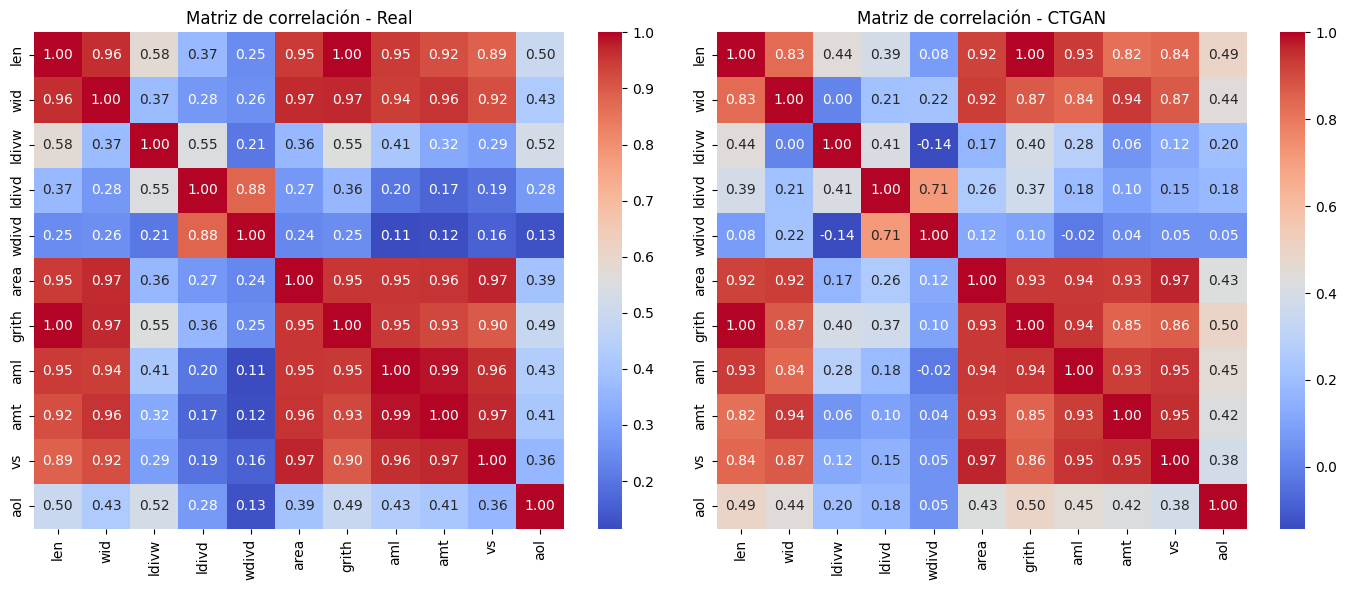

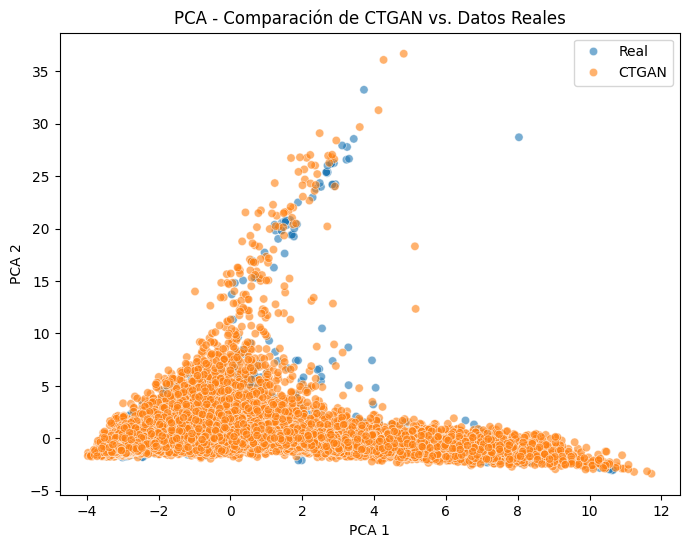

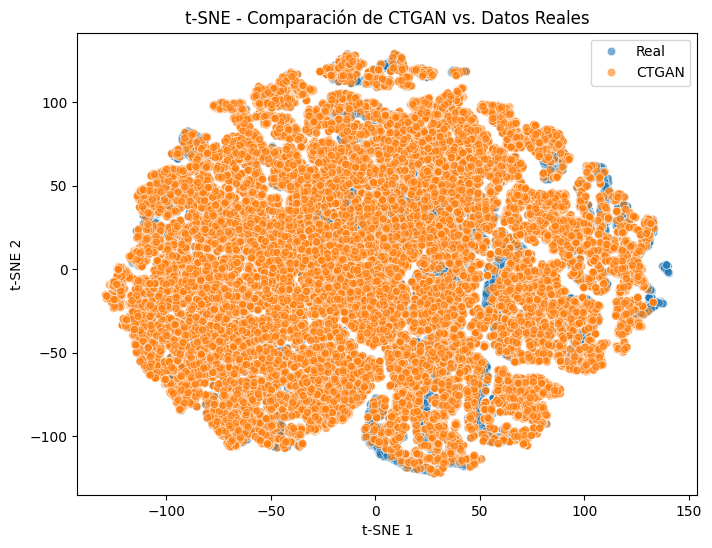


Comparación finalizada.



In [35]:
# Comparaciones independientes para cada técnica
comparar_con_reales(real_data, tvae_data, "TVAE")
comparar_con_reales(real_data, gaussian_data, "GaussianCopula")
comparar_con_reales(real_data, ctgan_data, "CTGAN")
